In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

%load_ext autoreload
%autoreload 2


In [2]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [4]:
torch.set_default_dtype(torch.float64)

## Setup data

In [5]:
dir_name = "./data/direct/"
file_name = "control.nc"

data = emulate.QBODataset(file_path=dir_name + file_name)

num_split = int((len(data))/2)

batch_size = 360

split_data = torch.utils.data.random_split(data, [num_split, num_split], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(split_data[0], batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(split_data[1], batch_size=batch_size, shuffle=True)

### This is what a batch of features (zonal wind) and labels (tendencies) in the training set look like after shuffling 

torch.Size([360, 73])


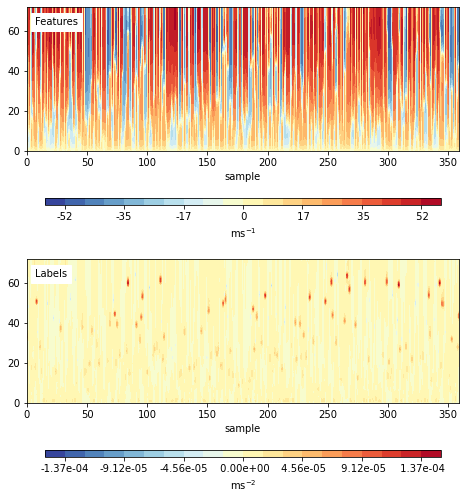

In [6]:
# plot training data
dataiter = iter(train_dataloader)
for i in range(47):
    features, labels = dataiter.next()

print(features.shape)
    
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 04.75, 06.00, 02.00])))
ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

h = []

cmin = -features.abs().max()
cmax = features.abs().max()

h.append(ax[0].contourf(features.T, 21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].set_xlabel('sample', fontsize=10)

ax[0].text(07.00, 67, "Features", horizontalalignment='left', verticalalignment='top', color='black', backgroundcolor='white', fontsize=10)

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 04.00, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')



cmin = -labels.abs().max()
cmax = labels.abs().max()

h.append(ax[1].contourf(labels.T, 21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[1].set_xlabel('sample', fontsize=10)

ax[1].text(07.00, 67, "Labels", horizontalalignment='left', verticalalignment='top', color='black', backgroundcolor='white', fontsize=10)


cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% .2e', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-2}}$')

## Setup model and optimizer

Hyperparameters were tuned by trial and error. I found that scaling the tendencies (labels) by their global absolute maximum works better than standardizing them (see results of emulation below). In addition, I found it unnecessary to scale the winds (features).

In [7]:
solver = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

model = emulate.FullyConnected(solver)

learning_rate = 1e-1
epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

scaler_Y = emulate.GlobalMaxScaler(data[:][1])
# scaler_Y = emulate.GlobalStandardScaler(data[:][1])

## Training

In order to properly emulate the tendencies, I found it necessary to drop the boundaries and train only on the interior. I was able to converge the error on the testing set to zero (i.e., "offline" testing), but the emulation ("online" testing) didn't work. During training, my network drops the boundaries of the input features and returns an output of size nlev-2. During emulation, when the self.training attribute of the model is set to False, the network adds zeros to the output boundaries so that it can be used by our code.

In [8]:
# training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss = 0
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, scaler_Y.transform(Y[:, 1:-1]))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
        with torch.no_grad():
            avg_loss += loss.item()
            
    avg_loss /= len(dataloader)
    
    return avg_loss

# testing loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    avg_loss = 0
    for batch, (X, Y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, scaler_Y.transform(Y[:, 1:-1]))
   
        with torch.no_grad():
            avg_loss += loss.item()
            
    avg_loss /= len(dataloader)
    
    return avg_loss

In [9]:
train_losses = []
test_losses = []

#### Next cell takes about 6 min to run on a cpu -- but is worthwhile waiting

In [10]:
# training
for t in range(epochs):
    if t % 10 ==0:
        print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, emulate.relative_MSELoss, optimizer)
    train_losses.append(train_loss)
    test_loss = test_loop(test_dataloader, model, emulate.relative_MSELoss)
    test_losses.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
Epoch 11
-------------------------------
Epoch 21
-------------------------------
Epoch 31
-------------------------------
Epoch 41
-------------------------------
Epoch 51
-------------------------------
Epoch 61
-------------------------------
Epoch 71
-------------------------------
Epoch 81
-------------------------------
Epoch 91
-------------------------------
Done!


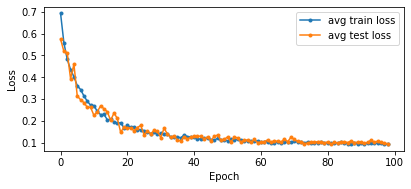

In [11]:
fig_size = (06.00, 02.75)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.60, 00.50, 05.00, 02.00])))

ax[0].plot(train_losses[1:], marker='.', color='C0', label="avg train loss")
ax[0].plot(test_losses[1:], marker='.', color='C1', label="avg test loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

In [12]:
# save model|
torch.save(model.state_dict(), './models/fully_connected.pth')

## Emulate using the trained model ("online")

In [13]:
torch.set_default_dtype(torch.float64)
solver = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)
model = utils.load_model(solver, ModelClass=emulate.FullyConnected, path_to_state_dict='./models/fully_connected.pth')
model.scaler_Y = scaler_Y
u = solver.solve(source_func=model)

In [14]:
u = u.detach()

In [15]:
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)

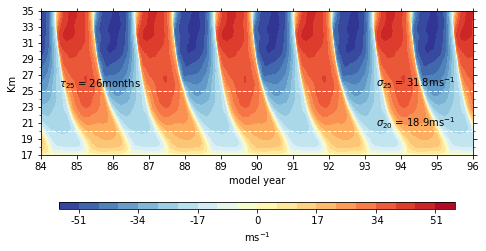

In [16]:
fig_size = (06.90, 02.20+01.50)
fig = plt.figure(figsize=fig_size)

ax = []

ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

cmin = -u.abs().max()
cmax = u.abs().max()

xmin = 84.
xmax = 96.
ymin = 17.
ymax = 35.

ax[0].set_xlim(left=84.)
ax[0].set_xlim(right=96.)
ax[0].set_ylim(bottom=17.)
ax[0].set_ylim(top=35.)

h = []
    
h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                        21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

ax[0].set_ylabel('Km', fontsize=10)

ax[0].set_xlabel('model year', fontsize=10)

xticks_list = np.arange(xmin, xmax+1, 1)
ax[0].set_xticks(xticks_list)

yticks_list = np.arange(ymin, ymax+2, 2)
ax[0].set_yticks(yticks_list)

xticklabels_list = list(xticks_list)
xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
ax[0].set_xticklabels(xticklabels_list, fontsize=10)

ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
ax[0].tick_params(which='both', labelbottom=True)

ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
              horizontalalignment='right', verticalalignment='bottom', color='black')

ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %tau25 + 'months',
              horizontalalignment='left', verticalalignment='bottom', color='black')

# # colorbars
cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
                      boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
                      label=r'$\mathrm{m s^{-1}}$')


The emulated solution is stable for 96 years with a period and amplitudes similar to the direct solution. I found there is some arbitrariness in the emulates solution. Repeating the learning from scratch can yield slightly different period and amplitude. In addition, the emulated solution is noticeably more periodic than the direct solution, but note that at this point the emulator doesn't include the dependence on the surface flux and spectral with of the stochastic forcing. In other words, we have emulates S=S(u), and not S=S(u,sf,cw) as should be for the stochastic forcing.